In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from datetime import date
from statistics import mean
from math import sqrt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import neural_network
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_rows", 144, "display.max_columns", 100)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def p(s):
    print(s)
    
pd.DataFrame.len = pd.Index.len = lambda x: print(len(x))

In [2]:
# Partition training, dev, and test data
seasonHist = pd.read_csv('seasonHist.csv')
X = seasonHist \
    .loc[:,seasonHist.columns.str.contains('-\d+') | seasonHist.columns.str.match('fanPts')] \
    .drop('fanPts',axis=1) \
    .fillna(0)
y = seasonHist.fanPts

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_dev_raw, X_test_raw, y_dev, y_test = train_test_split(X_test_raw, y_test, test_size=0.5, random_state=0)

# Scale and normalize data
mms = preprocessing.MinMaxScaler()
X_train_scaled = mms.fit_transform(X_train_raw)
X_dev_scaled, X_test_scaled = mms.transform(X_dev_raw), mms.transform(X_test_raw)

ss = preprocessing.StandardScaler()
X_train_std = ss.fit_transform(X_train_raw)
X_dev_std, X_test_std = ss.transform(X_dev_raw), ss.transform(X_test_raw)

# Manually downselect useful columns
keepCols = \
    X.columns.str.contains('fanPts') | \
    X.columns.str.contains('^complete_pass') | \
    X.columns.str.contains('rush_attempt') | \
    X.columns.str.contains('yards_gained') | \
    X.columns.str.contains('^touchdown')

X_train_select, X_dev_select, X_test_select = X_train_raw.loc[:,keepCols], X_dev_raw.loc[:,keepCols], X_test_raw.loc[:,keepCols]

### Multi-layer Perceptron Regression

#### Base model

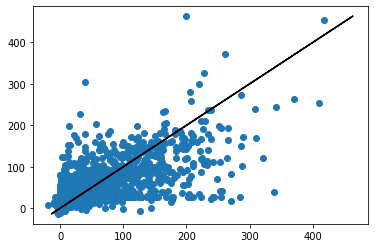

MAE: 32.2
RMSE: 48.4
R^2: 0.42


In [3]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = neural_network.MLPRegressor()
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_pred,y_pred,color='black')
plt.show()

print(f'MAE: {mean_absolute_error(y_dev, y_pred).round(1)}')
print(f'RMSE: {mean_squared_error(y_dev, y_pred, squared=False).round(1)}')
print(f'R^2: {r2_score(y_dev, y_pred).round(2)}')

#### GridSearchCV

In [ ]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

inputNodes = len(X_train.columns)
outputNodes = len(y_train.shape) if y_train.shape == 2 else 1
nSamples = len(X_train)

sizes = [
    mean([inputNodes,outputNodes]),
    (2/3)*inputNodes + outputNodes,
    sqrt(inputNodes*outputNodes),
] + [nSamples/(x*(inputNodes+outputNodes)) for x in range(2,11)] + [x for x in range(1,21)]

params={
    'activation':['relu'],#['identity','logistic','tanh','relu'],
    'solver':['lbfgs','adam'],
    'hidden_layer_sizes': list(set(map(int, sizes))),
    'alpha':[10**x for x in range(-5,1)],
}

params={
    'activation':['relu'],#['identity','logistic','tanh','relu'],
    'solver':['lbfgs','adam'],
    'hidden_layer_sizes': list(set(map(int, sizes))),
    'alpha':[10**x for x in range(-5,1)],
}

grid = GridSearchCV(
    neural_network.MLPRegressor(warm_start=False,random_state=0),
    params,
    n_jobs=-1,
    verbose=10,
    cv=5
).fit(X_train,y_train)

print(grid.best_params_)

m = neural_network.MLPRegressor(**grid.best_params_,warm_start=False,random_state=0)
%time m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

print(f'{m.n_iter_} iterations')
print(f'{m.n_layers_} layers')

plt.scatter(y_dev, y_pred)
plt.plot(y_pred,y_pred,color='black')
plt.show()

plt.plot(m.loss_curve_)

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

pd.DataFrame(grid.cv_results_)[['param_' + x for x in params.keys()]+['mean_test_score','std_test_score','rank_test_score','mean_fit_time','mean_score_time','std_fit_time','std_score_time']].set_index(['param_' + x for x in params.keys()])

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.3min
